# California 2017 Fire recovery 

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from shapely.geometry import Point, LineString, MultiPolygon, asMultiPolygon, Polygon
from shapely import wkb, wkt
import shapely
import geopandas as gpd
from shapely.ops import unary_union
import requests
from bs4 import BeautifulSoup
import re
import os
import zipfile
import wget
from datetime import datetime
from multiprocessing.dummy import Pool as ThreadPool 
%matplotlib inline

import sys
sys.path.insert(0, '/Users/jianglongli/Desktop/workbook/Freddie_project/PostGIS/gisfeaturecode_v7/')
from mapping_utility_v2 import map_geopandas, map_AllHouses
from python_postgis_talk_utility import transform_pd_to_gpd_general, transform_pd_to_gpd

pd.options.display.max_columns = 100

In [2]:
import warnings
warnings.simplefilter("ignore")

### geo processing functions

In [230]:
def get_boundary(df, quantile=1, crs=4326):
    low = (1-quantile)/2; high = quantile + low
    lat = 'lat'; lng = 'long'
    # set up four corners
    lower = df[lat].quantile(low)
    upper = df[lat].quantile(high)
    left = df[lng].quantile(low)
    right = df[lng].quantile(high)
    boundbox = (left, lower, right, upper, crs)
    return boundbox

def getInBoxPolygons(gdf, df=None, left=None, lower=None, right=None, upper=None):
#     gdf = fl
    if df is not None:
        left, lower, right, upper, crs = get_boundary(df)
    boundary = Polygon([(left, lower), (left, upper), (right, upper), (right, lower)])
    dfbox = gpd.GeoDataFrame({'geometry': [boundary], 'desc': ['boundary']}, crs={'init' :'epsg:4326'}, 
                             geometry='geometry')
    gdf_inBox = gdf[gdf.apply(lambda row: boundary.intersects(row['geometry']), axis=1)]
    return gdf_inBox

def geomatch(data, polygon, prmrkey_plgon, cols=None):
#     cols_plgon = ['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10', 'geometry']
#     prmrkey_plgon = 'GEOID10'
    cols_plgon = polygon.columns if cols is None else cols
    df = data.copy()
    gdf = getInBoxPolygons(polygon, df)
    df['geometry'] = df.apply(lambda row: Point(row['long'], row['lat']), axis=1)
    df = gpd.GeoDataFrame(df, crs={'init' :'epsg:4326'})
    result = gpd.sjoin(left_df=df, right_df=gdf[cols_plgon], how='left', op='intersects')
    result.drop(['geometry', 'index_right'], axis=1, inplace=True)
    result = result.merge(right=gdf[[prmrkey_plgon, 'geometry']], how='left', on = prmrkey_plgon)
    return result

def readin_shapefile(path_file):
    gdf = gpd.read_file(path_file)
    gdf = gdf.to_crs(crs={'init' :'epsg:4326'})
    gdf = gdf.rename(columns=lambda x: x.lower())
    return gdf

def timer():
    now = datetime.now()
    tformat = "%H:%M:%S"
    time = now.strftime(tformat)
    return time

### scraping functions

In [ ]:
def getsoup(url):
    res = requests.get(url)
#     res.raise_for_status()
    if res.ok == True:   # make sure the link isvalid and will not return error like 404
        soup = BeautifulSoup(res.content, "lxml")
        return soup
    else:
        pass

def get_firelinks(url, url_master):
    soup = getsoup(url)
    links = {}
    for inc in soup('a'):
        link = inc.attrs['href']
        name = inc.text
        if name != '[To Parent Directory]':
            links[name] = url_master + link
    return links

def get_zipfiles(url, url_master, download_type='zip'):
    soup = getsoup(url)
    links = []
    for inc in soup('a'):
        link = inc.attrs['href']
        name = inc.text
        if name != '[To Parent Directory]':
            links.append(url_master + link)
    if download_type == 'zip':
        links = [link for link in links if '.zip' in link]
    elif download_type == 'shp':
        links = [link for link in links if '.zip' not in link]
    return links

def get_firezips(url, url_master, download_type='zip'):
    fire_links = get_firelinks(url, url_master)
    size = 0
    for fire in fire_links:
        zips = get_zipfiles(fire_links[fire], url_master, download_type)
        size += len(zips)
        fire_links[fire] = zips
    fire_zips = fire_links
    print('totally %s zip files url parsed! %s' % (size, timer()))
    return fire_zips

def mkfolder(root, folder_list, verb=True):
    for sub in folder_list:
        if sub not in os.listdir(root):
            os.mkdir('%s/%s' % (root, sub))
            if verb: print('++++++++ folder %s created!' % (root + '/' + sub))

def download_fires(url, url_master, folder_root, folder_sub='cali_fire', download_type='zip', unzip=False, verb=True):
    # get all the fire shapefile link
    fire_zips = get_firezips(url, url_master, download_type)
    
    # create cali_fire from root folder
    mkfolder(folder_root, [folder_sub], verb)
    folder_cali = folder_root + '/' + folder_sub
    
    # for each fire incident create a sub folder and download the revevant files
    for fire in fire_zips:
        mkfolder(folder_cali, [fire]) # 1.create sub folder
        for url in fire_zips[fire]:
            pathfile = '/'.join([folder_root, folder_sub, fire, url.split('/')[-1]])
            if not os.path.exists(pathfile):
                path = folder_cali + '/' + fire
                file = wget.download(url, out=path) # 2.download (zip) files
                if verb: print('file %s downloaded!' % file)
                if unzip:
                    with zipfile.ZipFile(file, "r") as zip_ref: 
                        zip_ref.extractall(path=path) # 3.unzip file (optional)

def unzip_check(folder_root, folder_sub, verb=True):
    folder_cali = folder_root + '/' + folder_sub
    for folder in os.listdir(folder_cali):
        if folder != '.DS_Store':
            all_files = os.listdir(folder_cali + '/' + folder)
            zfiles = [file for file in all_files if file.split('.')[-1] == 'zip']
            for zfile in zfiles:
                shpfile = zfile.replace('zip', 'shp')
                pathshpfile = '/'.join([folder_cali, folder, shpfile])
                pathzfile = '/'.join([folder_cali, folder, zfile])
                if not os.path.exists(pathshpfile):
                    with zipfile.ZipFile(pathzfile, "r") as zip_ref: 
                        zip_ref.extractall(path=folder_cali + '/' + folder) # 3.unzip file (optional)
                    if verb: print('zip file %s got unzipped' % pathzfile)                        
                        
def retrieve_shp(folder_root, folder_sub):
    all_gdf = []
    for folder in os.listdir(folder_root + '/' + folder_sub):
        if re.match(r'\.\w+', folder) is None:
            for file in os.listdir('/'.join([folder_root, folder_sub, folder])):
                if file.split('.')[-1] == 'shp':
#                     gdf = gpd.read_file('/'.join([folder_root, folder_sub, folder, file]))
                    gdf = readin_shapefile('/'.join([folder_root, folder_sub, folder, file]))
                    all_gdf.append(gdf)
    df = pd.concat(all_gdf, ignore_index=True)
    return df


def download_and_create_shp(url_cali, url_master, folder_root, folder_sub, download_type='zip', unzip=True, verb=True):
    if verb: print("\n########## scraping start: %s ##########" % timer())
    download_fires(url_cali, url_master, folder_root, folder_sub, download_type, unzip, verb)
    
    if verb: print("\n########## check unzipped files: %s ##########" % timer())
    unzip_check(folder_root, folder_sub, verb)
    
    df = retrieve_shp(folder_root, folder_sub)
    return df

def download_read_curent_fire(folder_root, folder_sub = 'active_fire_US'):
    path = '/'.join([folder_root, folder_sub])
    mkfolder(folder_root, [folder_sub])
    if os.path.exists('/'.join([folder_root, folder_sub, 'active_perimeters_dd83.zip'])):
        os.remove('/'.join([folder_root, folder_sub, 'active_perimeters_dd83.zip']))
    url_active = """https://rmgsc.cr.usgs.gov/outgoing/GeoMAC/current_year_fire_data/current_year_all_states/\
active_perimeters_dd83.zip"""    
    file = wget.download(url=url_active, out=path)
    with zipfile.ZipFile(file, "r") as zip_ref: 
        zip_ref.extractall(path=path) # 3.unzip file (optional)
    pathfile = '/'.join([folder_root, folder_sub, 'active_perimeters_dd83.shp'])
    gdf = readin_shapefile(pathfile)
    return gdf

### fire data processing functions

In [224]:
def write_union_totxt(group, grp):
#     group = 'Abney'
#     union = gdf.loc[grp.groups[group],].groupby('firename')['geometry2'].apply(unary_union)
#     with open(pathfile, '+a') as f:
#     #     print("firename\tgeometry", file=f)
#         print('\t'.join([union.keys()[0], shapely.wkt.dumps(union.values[0])]),file=f)
    grouped = gdf.loc[grp.groups[group],].groupby('firename')
    geometry = grouped['geometry2'].agg({'geometry': unary_union})
    acres = grouped['gisacres'].agg({'max_gisacres': np.max})
    date = grouped['perdattime'].agg({'start_date': np.min, 'end_date': np.max})
    union = pd.concat([geometry, acres, date], axis=1).reset_index()
    return union

def fire_postprocessing(gdf):
    # name normalize
    gdf.loc[:, 'firename'] = gdf.firename.str.upper()
    gdf.loc[:, 'firename'] = gdf.firename.str.strip()

    # structure geometry2 and perdattime
    gdf.loc[:,'geometry2'] = gdf.apply(lambda row: row['geometry'].buffer(0) if not row['geometry'].is_valid 
                                       else row['geometry'], axis=1)
    gdf.loc[:, 'perdattime'] = pd.to_datetime(gdf.perdattime)
    return gdf

def create_fire_union(gdf, workers=6):
    grp = gdf.groupby('firename', )
    all_groups = list(grp.groups.keys())

    # pathfile = '/Users/jianglongli/Desktop/workbook/data/union.txt'
    # if os.path.exists(pathfile):
    #     os.remove(pathfile)
    # with open(pathfile, 'x') as f:
    #     print("firename\tgeometry", file=f)

#     workers = 7
    pool = ThreadPool(workers)
    all_union = pool.map(lambda x: write_union_totxt(x, grp), all_groups)
    gdf_union = pd.concat(all_union, ignore_index=True)
    # gdf_union = pd.DataFrame([dict(zip(['firename', 'geometry'], tuple(a.to_dict().items())[0])) for a in all_union])

#     gdf_union = gdf_union.rename(columns={'geometry2': 'geometry'})
    gdf_union = transform_pd_to_gpd(gdf_union, geometry='geometry')
    
    return gdf_union

### download shp files and create total geopandas dataframe

In [5]:
url_cali = "https://rmgsc.cr.usgs.gov/outgoing/GeoMAC/current_year_fire_data/California/"
url_master = "https://rmgsc.cr.usgs.gov"
folder_root = '/Users/jianglongli/Desktop/workbook/data'
folder_sub = 'cali_fire'

In [159]:
%%time
gdf = download_and_create_shp(url_cali, url_master, folder_root, folder_sub, 
                              download_type='zip', unzip=True, verb=True)


########## scraping start: 15:07:50 ##########
totally 1552 zip files url parsed! 15:11:47
file /Users/jianglongli/Desktop/workbook/data/cali_fire/Crown/ca_crown_20171030_1200_dd83.zip downloaded!

########## check unzipped files: 15:11:48 ##########
CPU times: user 45.2 s, sys: 2.6 s, total: 47.8 s
Wall time: 4min 40s


In [168]:
gdf = fire_postprocessing(gdf)

Ring Self-intersection at or near point -122.29322609958997 38.368854461891438
Ring Self-intersection at or near point -122.29322609958997 38.368854461891438
Ring Self-intersection at or near point -122.29322609958997 38.368854461891438
Ring Self-intersection at or near point -122.29322609959007 38.368854461891388
Ring Self-intersection at or near point -122.29322609958997 38.368854461891438
Ring Self-intersection at or near point -120.99716398229684 41.335605047406816
Ring Self-intersection at or near point -120.03658782922585 37.62942306856656
Ring Self-intersection at or near point -120.0365878176455 37.62942307763192
Ring Self-intersection at or near point -120.0365878288182 37.62942306858718
Ring Self-intersection at or near point -120.0365878176455 37.62942307763192
Ring Self-intersection at or near point -120.0365878288182 37.62942306858718
Ring Self-intersection at or near point -120.0365878176455 37.62942307763192
Ring Self-intersection at or near point -123.62637115611462 41.

In [225]:
%%time
gdf_union = create_fire_union(gdf, 6) 

CPU times: user 23min 16s, sys: 14.5 s, total: 23min 31s
Wall time: 13min 57s


In [232]:
%%time
print(timer())
result = geomatch(hve, gdf_union, 'firename')

20:33:50
CPU times: user 17min 5s, sys: 3.79 s, total: 17min 8s
Wall time: 17min 6s


**download current fire shapefile**

In [259]:
gdf_current_ca.head(1)

active agency comments compfirecd       complexnm  \
0      Y   USFS     None       K9PL  Miller Complex   

                                compparid    datecrnt firecode       firename  \
0  {08c7d95c-95de-4ee8-ba1e-0accc382d69c}  2017-08-26     None  WHISKEY RIDGE   

  firenum fireyear  gisacres         incidentid inciwebid incomplex  \
0  000563     2017  0.175192  2017-ORRSF-000563      None         Y   

                                  irwinid      mapmethod mergeid perdattime  \
0  {B62FBBD6-6296-46AC-946F-E40347922895}  Mixed Methods      {} 2017-08-26   

  state unitidown unitidprot  \
0    CA     ORRSF      ORRSF   

                                            geometry  \
0  POLYGON ((-123.21780564314 41.99014453898963, ...   

                                           geometry2  
0  POLYGON ((-123.21780564314 41.99014453898963, ...

In [261]:
gdf_current = download_read_curent_fire(folder_root)
gdf_current_ca = gdf_current[gdf_current.state == 'CA']
gdf_current_ca = fire_postprocessing(gdf_current_ca)
result_current = geomatch(hve, gdf_current_ca, 'firename', ['firename', 'geometry', 'perdattime'])

### fire impact reporting

+ **fire this year**

In [287]:
counts = result.firename.value_counts()
summary = pd.concat([counts.rename('count'), gdf_union.set_index('firename')], axis=1, join='inner')
summary = summary.reset_index().rename(columns={'index': 'firename'})
summary = transform_pd_to_gpd(summary, geometry='geometry')

In [284]:
summary.to_csv(folder_root + '/' + 'fire_summary.csv', index=False)

In [288]:
summary

firename  count  \
0                     TUBBS   7398   
1                     ATLAS   1777   
2                      NUNS   1523   
3                     ADOBE    616   
4                   CASCADE    296   
5   REDWOOD VALLEY INCIDENT    270   
6                    SULFUR    158   
7                MCCOURTNEY    105   
8                  PRESSLEY     61   
9                      LOBO     56   
10                 PARTRICK     47   
11                     WALL     42   
12                PONDEROSA     14   
13                   POCKET      4   
14                 CHEROKEE      4   
15                  NORBBOM      1   

                                             geometry  max_gisacres  \
0   (POLYGON ((-122.6134548656996 38.6200891587257...  36807.517535   
1   POLYGON ((-122.3005909321514 38.43933310930466...  51624.964582   
2   (POLYGON ((-122.414507893682 38.27942388804293...  56556.400807   
3   POLYGON ((-122.5701099670042 38.38694398988907...   8200.897210   
4   (POLYGON Z ((-121.340989771629 39.375039966058...  16529.887550   
5   (POLYGON ((-123.2709137386352 39.2791781085084...  36542.844708   
6   (POLYGON ((-122.5978861002088 38.9544320830586...   2448.953750   
7   POLYGON Z ((-121.0781211754822 39.203342724042...    529.471979   
8   POLYGON ((-122.6519005273975 38.35158626594198...    564.067714   
9   POLYGON Z ((-121.1344649304657 39.245012106701...    973.532241   
10  POLYGON ((-122.3679659111223 38.31501085789566...  10909.457296   
11  (POLYGON ((-121.4527935330307 39.5006491090010...   6080.725938   
12  POLYGON ((-121.2727826285532 39.60301769630585...   4015.732419   
13  POLYGON ((-122.94 38.77, -122.93 38.77, -122.9...  17360.096095   
14  POLYGON ((-121.6063892688607 39.56234492405365...   8415.803082   
15  POLYGON ((-122.4372372609266 38.33286897911823...   1835.887682   

            start_date            end_date  
0  2017-10-10 16:00:00 2017-10-25 21:30:00  
1  2017-10-09 22:34:00 2017-10-22 00:00:00  
2  2017-10-10 14:47:00 2017-10-25 21:30:00  
3  2017-10-10 14:47:00 2017-10-12 05:56:00  
4  2017-10-09 00:00:00 2017-10-15 19:45:00  
5  2017-10-09 21:09:00 2017-10-19 08:47:00  
6  2017-10-09 21:09:00 2017-10-19 08:47:00  
7  2017-10-09 01:30:00 2017-10-15 19:45:00  
8  2017-10-10 14:47:00 2017-10-18 21:51:00  
9  2017-10-09 00:00:00 2017-10-15 19:45:00  
10 2017-10-09 22:34:00 2017-10-12 05:56:00  
11 2017-07-08 01:25:00 2017-07-14 00:52:00  
12 2017-08-30 21:15:00 2017-09-06 01:30:00  
13 2017-10-10 16:00:00 2017-10-25 21:30:00  
14 2017-10-12 19:30:00 2017-10-12 19:30:00  
15 2017-10-09 22:34:00 2017-10-11 05:14:00

In [289]:
map_geopandas(summary, ckeep=['firename', 'geometry'], clabel='firename')

In [275]:
hve_onfire = result[result.firename.notnull()]
hve_onfire.drop('geometry', axis=1).to_csv('/Users/jianglongli/Desktop/workbook/data/hve_onfire.csv', index=False)

+ **current fire**

In [271]:
hve_onfire_current = result_current[result_current.firename.notnull()]
hve_onfire_current.firename.value_counts()

TUBBS       4884
NUNS        1172
ATLAS        635
PRESSLEY      23
POCKET         3
Name: firename, dtype: int64

In [272]:
hve_onfire_current.drop('geometry', axis=1).to_csv('/Users/jianglongli/Desktop/workbook/data/hve_onfire_current.csv', 
                                           index=False)

**Download current fire KML file and transform to geopandas dataframe**

In [8]:
# df.to_csv('/Users/jianglongli/Downloads/cali_fire.csv', index=False)

### read in hve turned off file and try matching

In [248]:
hve = pd.read_csv('/Users/jianglongli/Desktop/workbook/data/cali_turnedoff/cali_turned_off.csv', dtype={'zip': str})
hve.loc[:, 'long'] = hve['long'].apply(lambda x: -x if x>0 else x)
hve = hve[hve.lat.notnull()]
hve.shape

(324931, 6)

In [250]:
hve.head()

address    zip             city        lat        long         lnno
0   1 CORBIN DR  94503  AMERICAN CANYON  38.159302 -122.254436  755084381.0
1  1 GREGORY LN  94503  AMERICAN CANYON  38.160105 -122.240112  411986465.0
2    1 KAREN DR  94503  AMERICAN CANYON  38.158616 -122.242040  777915049.0
3    1 KEVIN LN  94503  AMERICAN CANYON  38.159498 -122.239985  635576317.0
4     1 LENA DR  94503  AMERICAN CANYON  38.155846 -122.258138  422338532.0

In [7]:
gdf.loc[:, 'id_manual'] = np.arange(gdf.shape[0])
gdf.loc[:, 'id_manual'] = gdf['id_manual'].astype(str)

In [13]:
%%time
result = geomatch(hve, gdf, cols_plgon=['id_manual', 'firename', 'geometry'], prmrkey_plgon='id_manual')

CPU times: user 2h 27min 35s, sys: 34.8 s, total: 2h 28min 9s
Wall time: 2h 40min 49s


In [105]:
result_current[result_current.id_manual.notnull()].firename.unique()

array(['TUBBS', 'ATLAS', 'NUNS', 'Pressley', 'Pocket'], dtype=object)

In [103]:
result_current.id_manual.notnull().sum()

6717

### Mapping

In [311]:
map_geopandas(gdf=df.sample(15), ckeep=['firename', 'geometry'], clabel='firename')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


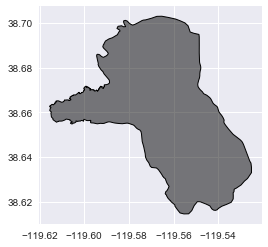

In [38]:
df.plot()

In [55]:
map_geopandas(gdf_active[gdf_active.state == 'CA'], ckeep=['firename', 'geometry'], clabel='firename')

# Reference

+ **GeoMAC data, part of USGS, this data provides file polygons**: https://www.geomac.gov/index.shtml 
    - shapefile: https://rmgsc.cr.usgs.gov/outgoing/GeoMAC/
    - data attribute definition: 
        * https://www.nwcg.gov/sites/default/files/stds/WildlandFirePerimeters_definition.pdf
        * https://rmgsc.cr.usgs.gov/outgoing/GeoMAC/historic_fire_data/perimeters_dd83_METADATA.htm
    - curent file perimeter methodology: https://www.geomac.gov/viewer/help/perimeters_active.html    
    - GeoMAC map viewer help and documentation:https://www.geomac.gov/viewer/help/Help.html
    - a 2008 publication about GeoMAC: https://pubs.usgs.gov/ds/612/pdf/ds612.pdf
    - a 2008 GeoMAC user guide: https://webarchive.library.unt.edu/eot2008/20080916004656/http://geomac.gov/pdf/UsersGuide/GeoMAC_UG.pdf


+ **USGS**: https://www.usgs.gov/centers/gecsc


+ **Data Basin view of GeoMAC**: https://databasin.org/datasets/6ed18e2a72e74b0d81e14c93d5b46f07


+ **NASA Fire Information for Resource Management System (FIRMS), mostly point data, near real time**: https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms


+ **CA fire org, has google map fire range, but not sure how to get the shapefile**: http://www.calfire.ca.gov/general/firemaps
    - FRAP program from Cal Fire also has fire perimeter data: http://frap.fire.ca.gov/data/frapgisdata-sw-fireperimeters_download
    
    
+ **KML file tutorial**: https://developers.google.com/kml/documentation/kml_tut

# Note

**GeoMAC fire perimeters:**
his layer contains fire perimeters that are submitted to GeoMAC by field offices. The fire perimeters are updated every one or two days, as the data is made available. If we have received no new data, the "expired" layer is not replaced. The layer is replaced as soon as we receive an updated file. Perimeters are usually collected on a daily basis for large fires that are growing. However, there may be gaps in daily coverage.

The GeoMAC team attributes the perimeters using the IRWIN (Integrated Reporting of Wildland-Fire Information) system.

Perimeters are collected in the field by a variety of means, including infrared flights, and by using a GPS unit to map the perimeter. Please NOTE: GeoMAC only displays perimeter data as they are submitted by field offices. Since data are not received for all fires, you may not be able to view perimeters for every fire.

Perimeter data displayed in and delivered by the Geomac application is not the final or official perimeter for any incident and is provided for informational purposes only. The final official perimeter should be obtained from the host unit which can be determined by looking at the Unit Id for any specific fire. The host unit is responsible for producing official and final perimeters for all incidents in their jurisdiction.


**Cal Fire**: 
As part of the California Fire Plan, the Fire and Resource Assessment Program (FRAP) compiles fire perimeters and has established an on-going fire perimeter data capture process in order to update vegetative fuel rank maps. CAL FIRE/FRAP, the USDA Forest Service Region 5 Remote Sensing Lab, the Bureau of Land Management, and the National Park Service jointly develop the comprehensive fire perimeter GIS layer for public and private lands throughout California.

The fire perimeter database represents the most complete digital record of fire perimeters in California. However it is still incomplete in many respects. Fire perimeter database users must exercise caution to avoid inaccurate or erroneous conclusions. For more information on potential errors and their source please review the methodology section of these pages.

# Web Scraping reflection
+ try scrapy (scrapy vs beautifulsoup): https://blog.michaelyin.info/2017/08/10/scrapy-tutorial-1-scrapy-vs-beautiful-soup/

+ scrapy is a framework: https://hexfox.com/p/scrapy-vs-beautifulsoup/